In [396]:
pip install tensorflow stable_baselines3 gym gym_anytrading ipykernel finta

Note: you may need to restart the kernel to use updated packages.


In [397]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [398]:
df = pd.read_csv('spy_data.csv')

In [399]:
df.head()

,Date,Open,High,Low,Close,Volume
0,03/05/2024,510.24,510.70,504.91,507.18,"72,855,617"
1,03/04/2024,512.03,514.20,512.00,512.30,"49,799,262"
2,03/01/2024,508.98,513.29,508.56,512.85,"76,844,844"
3,02/29/2024,508.07,509.74,505.35,508.08,"83,924,797"
4,02/28/2024,505.33,506.86,504.96,506.26,"56,506,633"


In [400]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume            object
dtype: object

In [401]:
df.sort_values('Date', ascending=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
251,2023-03-06,405.05,407.45,404.01,404.47,"72,795,953"
250,2023-03-07,404.42,404.67,397.63,398.27,"108,310,602"
249,2023-03-08,398.39,399.71,396.59,398.92,"74,746,633"
248,2023-03-09,399.74,401.48,390.53,391.56,"111,945,297"
247,2023-03-10,390.99,393.16,384.32,385.91,"189,252,984"


In [402]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-06,405.05,407.45,404.01,404.47,"72,795,953"
2023-03-07,404.42,404.67,397.63,398.27,"108,310,602"
2023-03-08,398.39,399.71,396.59,398.92,"74,746,633"
2023-03-09,399.74,401.48,390.53,391.56,"111,945,297"
2023-03-10,390.99,393.16,384.32,385.91,"189,252,984"


In [403]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,250), window_size=5)

In [404]:
env.action_space

Discrete(2)

info: {'total_reward': 49.739990234375, 'total_profit': 0.45178394850800857, 'position': <Positions.Short: 0>}


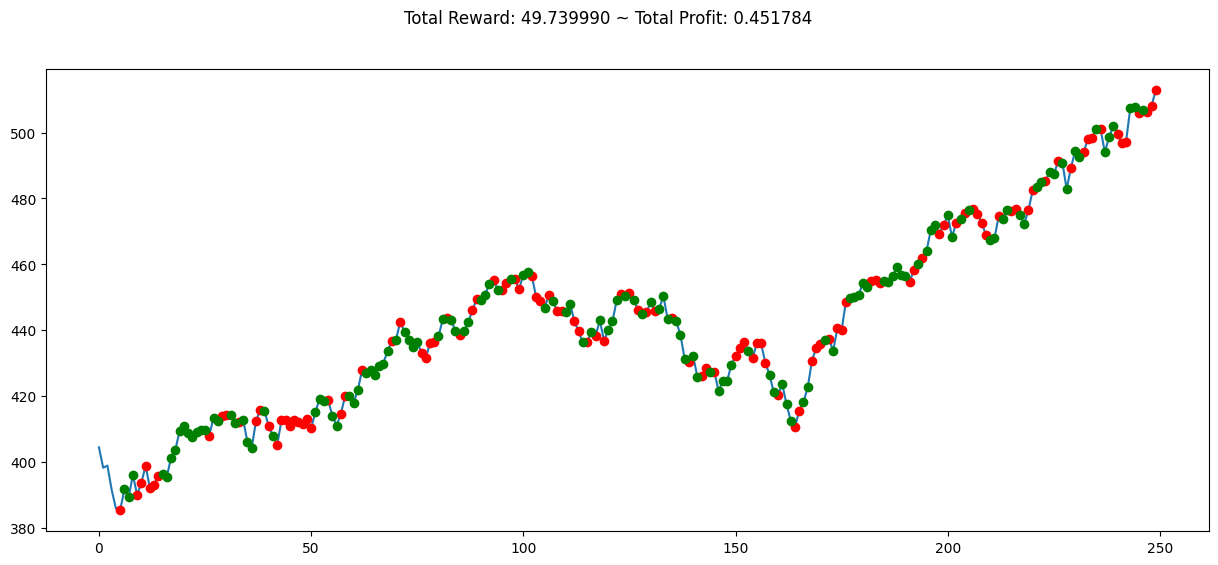

In [405]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        print("info:", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.unwrapped.render_all()
plt.show()

In [406]:
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))

In [407]:
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [408]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-06,405.05,407.45,404.01,404.47,72795953.0
2023-03-07,404.42,404.67,397.63,398.27,108310602.0
2023-03-08,398.39,399.71,396.59,398.92,74746633.0
2023-03-09,399.74,401.48,390.53,391.56,111945297.0
2023-03-10,390.99,393.16,384.32,385.91,189252984.0


In [409]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [410]:
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2023-03-06,405.05,407.45,404.01,404.47,72795953.0,0.0,0.000000,0.0
2023-03-07,404.42,404.67,397.63,398.27,108310602.0,0.0,0.000000,-108310602.0
2023-03-08,398.39,399.71,396.59,398.92,74746633.0,0.0,10.144928,-33563969.0
2023-03-09,399.74,401.48,390.53,391.56,111945297.0,0.0,4.534895,-145509266.0
2023-03-10,390.99,393.16,384.32,385.91,189252984.0,0.0,3.112139,-334762250.0


In [411]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [412]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,250))

In [413]:
env2.signal_features

array([[ 4.04010000e+02,  7.27959530e+07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.97630000e+02,  1.08310602e+08,  0.00000000e+00,
         0.00000000e+00, -1.08310602e+08],
       [ 3.96590000e+02,  7.47466330e+07,  0.00000000e+00,
         1.01449275e+01, -3.35639690e+07],
       ...,
       [ 5.04960000e+02,  5.65066330e+07,  5.01970833e+02,
         6.51402291e+01,  1.61204001e+09],
       [ 5.05350000e+02,  8.39247970e+07,  5.02562500e+02,
         6.68554944e+01,  1.69596481e+09],
       [ 5.08560000e+02,  7.68448440e+07,  5.04126667e+02,
         7.08972699e+01,  1.77280965e+09]])

In [414]:
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2023-03-06,405.05,407.45,404.01,404.47,72795953.0,0.0,0.000000,0.0
2023-03-07,404.42,404.67,397.63,398.27,108310602.0,0.0,0.000000,-108310602.0
2023-03-08,398.39,399.71,396.59,398.92,74746633.0,0.0,10.144928,-33563969.0
2023-03-09,399.74,401.48,390.53,391.56,111945297.0,0.0,4.534895,-145509266.0
2023-03-10,390.99,393.16,384.32,385.91,189252984.0,0.0,3.112139,-334762250.0


In [415]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [431]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 169      |
|    ep_rew_mean        | 12.9     |
| time/                 |          |
|    fps                | 2956     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | -0.036   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.33     |
|    value_loss         | 7.02     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 169      |
|    ep_rew_mean        | 22.6     |
| time/                 |          |
|    fps                | 3042     |
|    iterations         | 200      |
|    time_elapsed 

In [438]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(80,250))
obs, info = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 82.66000000000008, 'total_profit': 0.7279194000236313, 'position': <Positions.Long: 1>}


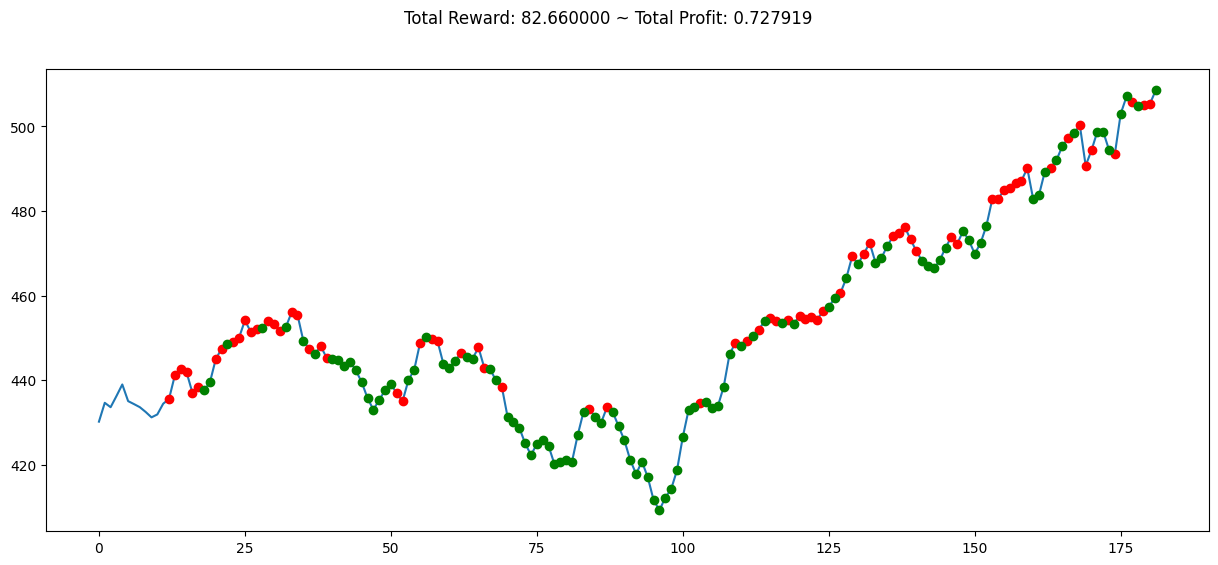

In [439]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()